In [1]:
import pandas as pd

df = pd.read_csv('cleaned_crime.csv')

In [2]:
df = df.dropna(subset=['LAT', 'LON'])
df = df[(df['LAT'] != 0) & (df['LON'] != 0)]

In [3]:
import geopandas as gpd
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df['LON'], df['LAT'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')

In [5]:
la_map = gpd.read_file('Neighborhood_Councils_(Certified).geojson')
la_map = la_map.to_crs(epsg=4326)

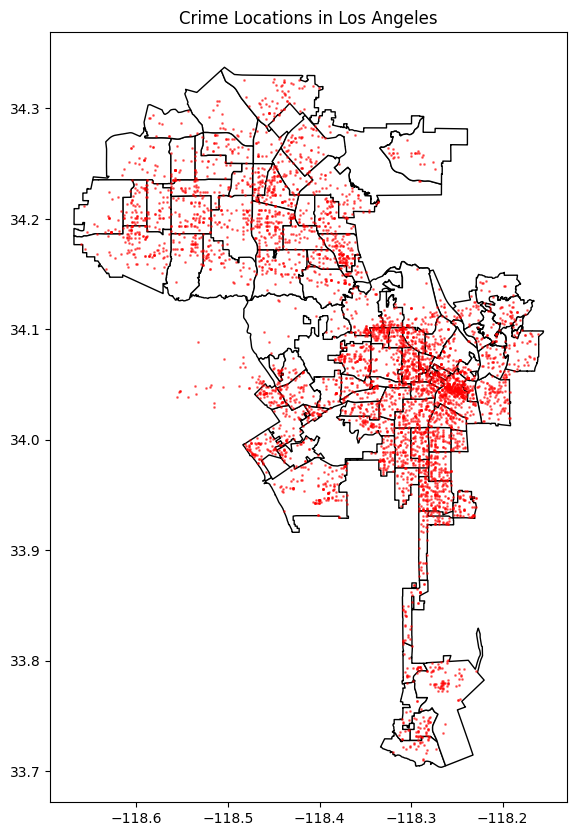

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))
la_map.plot(ax=ax, color='white', edgecolor='black')
gdf.sample(5000).plot(ax=ax, markersize=1, color='red', alpha=0.5)
plt.title("Crime Locations in Los Angeles")
plt.show()

In [9]:
gdf_joined = gpd.sjoin(gdf, la_map, how='inner', predicate='within')

crime_counts = gdf_joined.groupby('NAME').size().reset_index(name='crime_count')

la_map = la_map.merge(crime_counts, on='NAME', how='left')
la_map['crime_count'] = la_map['crime_count'].fillna(0)

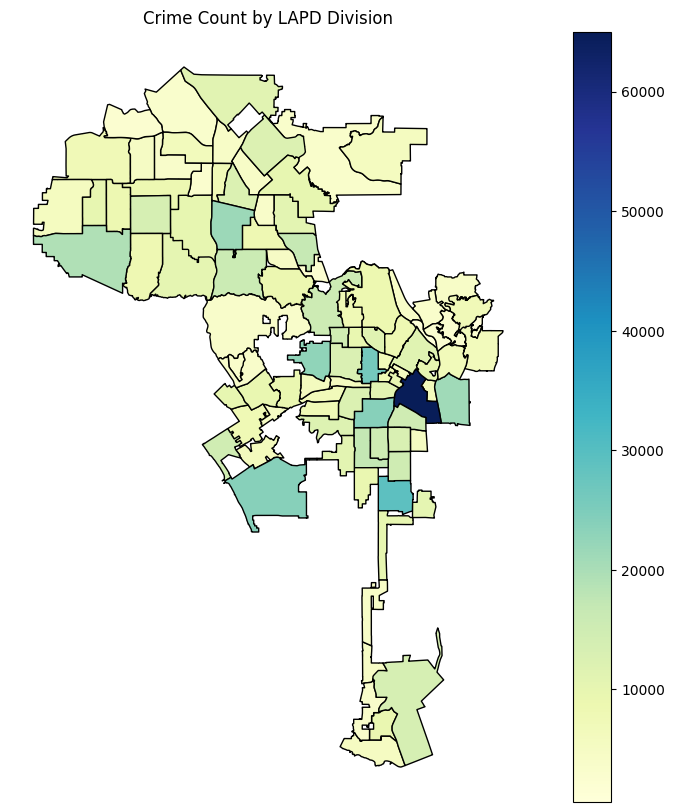

In [13]:
fig, ax = plt.subplots(figsize=(12, 10))
la_map.plot(column='crime_count', ax=ax, cmap='YlGnBu', legend=True, edgecolor='black')
plt.title('Crime Count by LAPD Division')
plt.axis('off')
plt.show()

In [15]:
import folium
from folium.plugins import HeatMap

m = folium.Map(location=[34.05, -118.25], zoom_start=11)

heat_data = [[row['LAT'], row['LON']] for index, row in df.sample(10000).iterrows()]
HeatMap(heat_data).add_to(m)

m.save('la_crime_heatmap.html')